In [1]:
import pandas as pd
import geopandas as gp
import os
from helper_functions import *
pd.options.display.max_columns = 100


#Raw election results from state
df = pd.read_table("./raw-from-source/results_pct_20221108.txt", sep = "\t")
#RDH created PBER file
pber = gp.read_file("./nc_2022_gen_prec/nc_2022_gen_prec.shp")
#2022 NC State leg plans
sldu = gp.read_file("./nc_sldu_adopted_2022/SL 2022-2.shp")


#Standardize district col in district gdfs
sldu['SU_DIST']=sldu["DISTRICT"].astype(str).str.zfill(2)


#Make district gdf crs match pber gdf to enable overlay
sldu = sldu.to_crs(pber.crs)


#District gdfs - to be modified
pber['SLDU_DIST'] = "NA"
pber_sldu = pber[["UNIQUE_ID","COUNTYFP","COUNTYNM","PRECINCT", "SLDU_DIST"]+list(pber.columns[(pber.columns.str.contains("GSU"))])+["geometry"]]

In [2]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSU":
        level = "SU"
        dist = column_name[3:5]
    elif column_name[0:3] == "GCO":
        level = "CON"
        dist = column_name[4:6]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]


        
from collections import Counter
races = [i for i in list(pber_sldu.columns) if "GSU" in i]
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pber_sldu.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    
    
    
#PH cong dist code
def return_su(row):
    for val in races:
        if row[val] != 0:
            return val[3:5]
        
        
pber_sldu["SLDU_DIST"] = pber_sldu.apply(lambda row: return_su(row), axis = 1)


split_precincts_list

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


{'WAKE---PRECINCT 04-11': {'SU': ['15', '16']},
 'WAKE---PRECINCT 17-01': {'SU': ['13', '14']},
 'WAKE---PRECINCT 20-08': {'SU': ['16', '17']},
 'CUMBERLAND---CC519': {'SU': ['19', '21']}}

In [3]:
pber_sldu[pber_sldu['SLDU_DIST'].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDU_DIST,GSU01RSAN,GSU02RPER,GSU03DJOR,GSU03RHAN,GSU04DFIT,GSU04RNEW,GSU05DSMI,GSU05RKOZ,GSU06RLAZ,GSU07DMOR,GSU07RLEE,GSU08RRAB,GSU09RJAC,GSU10DCOH,GSU10RSAW,GSU11DSPE,GSU11RBAR,GSU12DCHA,GSU12RBUR,GSU13DGRA,GSU13LMUN,GSU13RBAN,GSU14DBLU,GSU14LLAS,GSU14RBAK,GSU15DCHA,GSU15LBRO,GSU15RPRI,GSU16DADC,GSU16GTRU,GSU16LWAT,GSU16RPOW,GSU17DBAT,GSU17LBOW,GSU17RCAV,GSU18DBOD,GSU18LBRO,GSU18RSYK,GSU19DAPP,GSU19RMER,GSU20DMUR,GSU20RREE,GSU21DMCN,GSU21RMCI,GSU22DWOO,GSU22LUBI,GSU22RCOL,GSU23DMEY,GSU23RWOO,GSU24DGIB,GSU24RBRI,GSU25DEWI,GSU25RGAL,GSU26OWRI,GSU26RBER,GSU27DGAR,GSU27RSES,GSU28DROB,GSU28RSCH,GSU29DCRU,GSU29RCRA,GSU30DJOH,GSU30RJAR,GSU31RKRA,GSU32DLOW,GSU32RWAR,GSU33DHOR,GSU33RFOR,GSU34DSAN,GSU34RNEW,GSU35RJOH,GSU36RSET,GSU37RSAW,GSU38DMOH,GSU39DSAL,GSU39RROB,GSU40DWAD,GSU40RSHI,GSU41DMAR,GSU41RLEO,GSU42DHUN,GSU42RRUS,GSU43ROVE,GSU44RALE,GSU45RPRO,GSU46DMAR,GSU46RDAN,GSU47RHIS,GSU48DCAR,GSU48RMOF,GSU49DMAY,GSU49RAND,GSU50DMCC,GSU50RCOR,geometry


In [4]:
for val in pber_sldu["UNIQUE_ID"]:
    cd_list = []
    if val in split_precincts_list.keys():
        print(val)
        join_attempt_1 = district_splits_mod(split_precincts_list[val],"SLDU",val, pber_sldu, sldu, "UNIQUE_ID", "SU_DIST", races, "SLDU_DIST")

WAKE---PRECINCT 04-11
WAKE---PRECINCT 17-01
WAKE---PRECINCT 20-08
CUMBERLAND---CC519


In [5]:
join_attempt_1[join_attempt_1['UNIQUE_ID'].str.contains("SLDU")]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDU_DIST,GSU01RSAN,GSU02RPER,GSU03DJOR,GSU03RHAN,GSU04DFIT,GSU04RNEW,GSU05DSMI,GSU05RKOZ,GSU06RLAZ,GSU07DMOR,GSU07RLEE,GSU08RRAB,GSU09RJAC,GSU10DCOH,GSU10RSAW,GSU11DSPE,GSU11RBAR,GSU12DCHA,GSU12RBUR,GSU13DGRA,GSU13LMUN,GSU13RBAN,GSU14DBLU,GSU14LLAS,GSU14RBAK,GSU15DCHA,GSU15LBRO,GSU15RPRI,GSU16DADC,GSU16GTRU,GSU16LWAT,GSU16RPOW,GSU17DBAT,GSU17LBOW,GSU17RCAV,GSU18DBOD,GSU18LBRO,GSU18RSYK,GSU19DAPP,GSU19RMER,GSU20DMUR,GSU20RREE,GSU21DMCN,GSU21RMCI,GSU22DWOO,GSU22LUBI,GSU22RCOL,GSU23DMEY,GSU23RWOO,GSU24DGIB,GSU24RBRI,GSU25DEWI,GSU25RGAL,GSU26OWRI,GSU26RBER,GSU27DGAR,GSU27RSES,GSU28DROB,GSU28RSCH,GSU29DCRU,GSU29RCRA,GSU30DJOH,GSU30RJAR,GSU31RKRA,GSU32DLOW,GSU32RWAR,GSU33DHOR,GSU33RFOR,GSU34DSAN,GSU34RNEW,GSU35RJOH,GSU36RSET,GSU37RSAW,GSU38DMOH,GSU39DSAL,GSU39RROB,GSU40DWAD,GSU40RSHI,GSU41DMAR,GSU41RLEO,GSU42DHUN,GSU42RRUS,GSU43ROVE,GSU44RALE,GSU45RPRO,GSU46DMAR,GSU46RDAN,GSU47RHIS,GSU48DCAR,GSU48RMOF,GSU49DMAY,GSU49RAND,GSU50DMCC,GSU50RCOR,geometry
2654,CUMBERLAND---CC519-(SLDU-19),51,CUMBERLAND,CC519,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((2042695.858 473223.784, 2042601.817 ..."
2655,CUMBERLAND---CC519-(SLDU-21),51,CUMBERLAND,CC519,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,509,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((2032466.194 479703.479, 2032479.054 ..."


In [6]:
join_attempt_1[join_attempt_1["SLDU_DIST"].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDU_DIST,GSU01RSAN,GSU02RPER,GSU03DJOR,GSU03RHAN,GSU04DFIT,GSU04RNEW,GSU05DSMI,GSU05RKOZ,GSU06RLAZ,GSU07DMOR,GSU07RLEE,GSU08RRAB,GSU09RJAC,GSU10DCOH,GSU10RSAW,GSU11DSPE,GSU11RBAR,GSU12DCHA,GSU12RBUR,GSU13DGRA,GSU13LMUN,GSU13RBAN,GSU14DBLU,GSU14LLAS,GSU14RBAK,GSU15DCHA,GSU15LBRO,GSU15RPRI,GSU16DADC,GSU16GTRU,GSU16LWAT,GSU16RPOW,GSU17DBAT,GSU17LBOW,GSU17RCAV,GSU18DBOD,GSU18LBRO,GSU18RSYK,GSU19DAPP,GSU19RMER,GSU20DMUR,GSU20RREE,GSU21DMCN,GSU21RMCI,GSU22DWOO,GSU22LUBI,GSU22RCOL,GSU23DMEY,GSU23RWOO,GSU24DGIB,GSU24RBRI,GSU25DEWI,GSU25RGAL,GSU26OWRI,GSU26RBER,GSU27DGAR,GSU27RSES,GSU28DROB,GSU28RSCH,GSU29DCRU,GSU29RCRA,GSU30DJOH,GSU30RJAR,GSU31RKRA,GSU32DLOW,GSU32RWAR,GSU33DHOR,GSU33RFOR,GSU34DSAN,GSU34RNEW,GSU35RJOH,GSU36RSET,GSU37RSAW,GSU38DMOH,GSU39DSAL,GSU39RROB,GSU40DWAD,GSU40RSHI,GSU41DMAR,GSU41RLEO,GSU42DHUN,GSU42RRUS,GSU43ROVE,GSU44RALE,GSU45RPRO,GSU46DMAR,GSU46RDAN,GSU47RHIS,GSU48DCAR,GSU48RMOF,GSU49DMAY,GSU49RAND,GSU50DMCC,GSU50RCOR,geometry


In [7]:
join_attempt_1.shape

(2656, 100)

### Totals Checks

In [8]:
county_totals_check(pber, "pber", join_attempt_1, "join",races, "COUNTYFP")
statewide_totals_check(pber, "pber", join_attempt_1, "join",races)

***Countywide Totals Check***

GSU01RSAN is equal across all counties
GSU02RPER is equal across all counties
GSU03DJOR is equal across all counties
GSU03RHAN is equal across all counties
GSU04DFIT is equal across all counties
GSU04RNEW is equal across all counties
GSU05DSMI is equal across all counties
GSU05RKOZ is equal across all counties
GSU06RLAZ is equal across all counties
GSU07DMOR is equal across all counties
GSU07RLEE is equal across all counties
GSU08RRAB is equal across all counties
GSU09RJAC is equal across all counties
GSU10DCOH is equal across all counties
GSU10RSAW is equal across all counties
GSU11DSPE is equal across all counties
GSU11RBAR is equal across all counties
GSU12DCHA is equal across all counties
GSU12RBUR is equal across all counties
GSU13DGRA is equal across all counties
GSU13LMUN is equal across all counties
GSU13RBAN is equal across all counties
GSU14DBLU is equal across all counties
GSU14LLAS is equal across all counties
GSU14RBAK is equal across all cou

### Check district assignments

In [9]:
## Intersect the District with GA_CONG to fill in the n/a values
na_values = join_attempt_1[join_attempt_1["SLDU_DIST"].isna()]
others = join_attempt_1[~(join_attempt_1["SLDU_DIST"].isna())]

In [10]:
print(join_attempt_1.shape)
print(others.shape)
print(na_values.shape)

(2656, 100)
(2656, 100)
(0, 100)


In [11]:
intersected = gp.overlay(sldu, na_values, how = "intersection")


# Create a dictionary to map
intersected['area'] = intersected.area
na_assignment_dict = {}
for val in intersected["UNIQUE_ID"].unique():

    assignment = intersected.loc[intersected["UNIQUE_ID"] == val].nlargest(1, 'area')["SU_DIST"].values[0]
    na_assignment_dict[val] = assignment
    

join_attempt_1["SLDU_DIST"] = join_attempt_1["UNIQUE_ID"].map(na_assignment_dict).fillna(join_attempt_1["SLDU_DIST"])


assigned_districts = join_attempt_1.dissolve(["SLDU_DIST"])
assigned_districts.reset_index(drop=False,inplace=True)


sldu["SLDU_DIST"] = sldu["SU_DIST"]

Checking 50 precincts for differences of greater than 0.1 km^2

1) For 13 difference in area is 0.2606936560317297
2) For 14 difference in area is 0.2606978933527399
3) For 15 difference in area is 0.247901427211183
4) For 16 difference in area is 0.4018993032508714
5) For 17 difference in area is 0.15400836882625374

Scroll down to see plots of any differences

Of the 50 precincts:

0 precincts w/ a difference of 0 km^2
45 precincts w/ a difference between 0 and .1 km^2
5 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


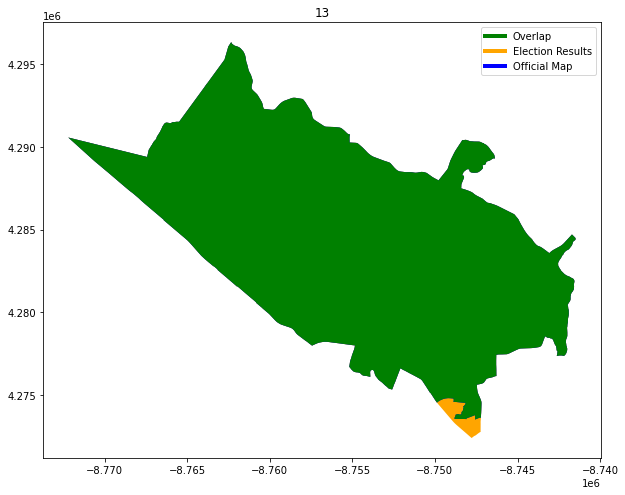

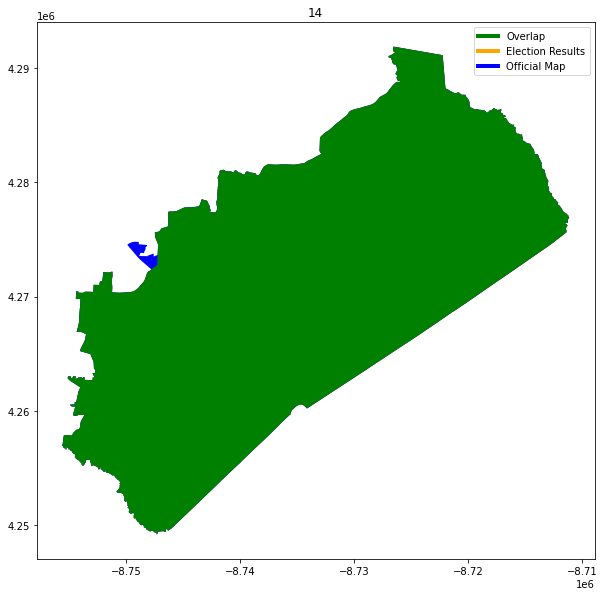

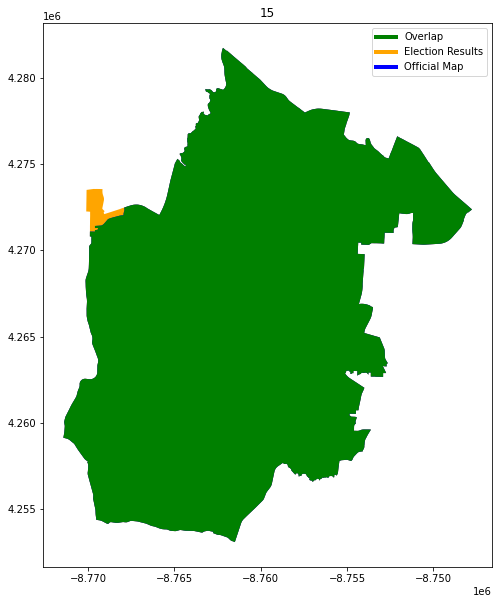

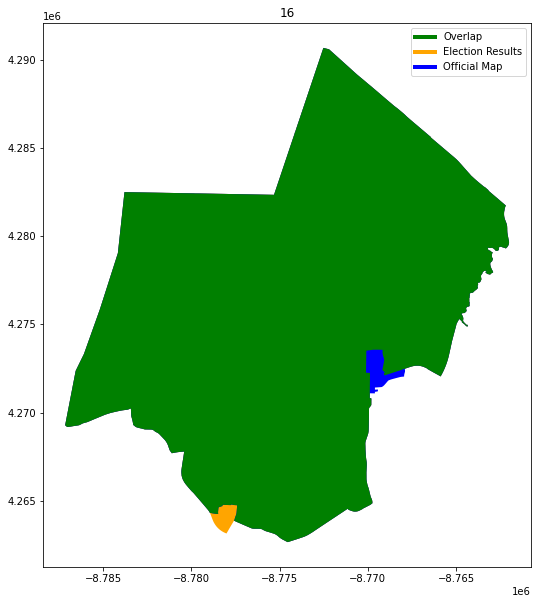

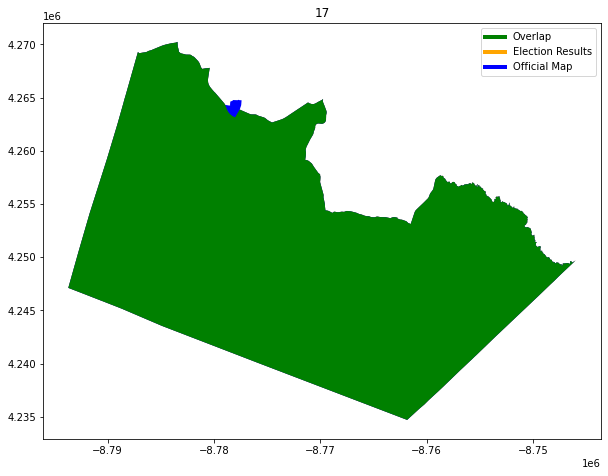

In [12]:
compare_geometries(assigned_districts, sldu,"Election Results", "Official Map", "SLDU_DIST",area_threshold=.1)

## Prepare to export

In [13]:
join_attempt_1.to_file("./nc_2022_gen_prec/nc_gen_22_sldu_prec.shp")